# Strain Mapping

This tutorial demonstrates different routes to obtain strain maps from scanning electron diffraction data.

The code functionality is illustrated using synthetic data, which is first generated using pyxem. This synthetic data represents a simple cubic crystal that is distorted to a tetragonal stucture. The intention is for this to provide an easy to understand illustration of the code functionality rather than to model any physical system.

This functionaility has been checked to run in pyxem-0.13.0 (Jan 2021). Bugs are always possible, do not trust the code blindly, and if you experience any issues please report them here: https://github.com/pyxem/pyxem-demos/issues

## Contents

1. <a href='#gen'> Setting up & Creating Synthetic Data</a>
2. <a href='#aff'> Image Affine Transform Based Mapping</a>
3. <a href='#vec'> Vector Based Mapping</a>

<a id='gen'></a>

##  1. Setting up & Creating Synthetic Data

Import pyxem and other required libraries

In [1]:
%matplotlib inline
import pyxem as pxm
import numpy as np
import hyperspy.api as hs
import diffpy.structure
from matplotlib import pyplot as plt
from pyxem.generators.indexation_generator import IndexationGenerator
from diffsims.generators.diffraction_generator import DiffractionGenerator

Define a structure for the creation of synthetic data

In [2]:
latt = diffpy.structure.lattice.Lattice(3,3,3,90,90,90)
atom = diffpy.structure.atom.Atom(atype='Ni',xyz=[0,0,0],lattice=latt)
structure = diffpy.structure.Structure(atoms=[atom],lattice=latt)

Simulate an electron diffraction pattern

In [3]:
ediff = DiffractionGenerator(300.)
diffraction = ediff.calculate_ed_data(structure,
                                      reciprocal_radius=5.,
                                      max_excitation_error=0.025, 
                                      with_direct_beam=False)

check we have some spots

(<AxesSubplot:>, <matplotlib.collections.PathCollection at 0x7f120d9c6e48>)

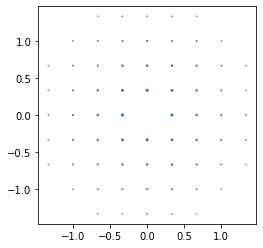

In [4]:
diffraction.plot()

and that they play nice with our "detector" configuration

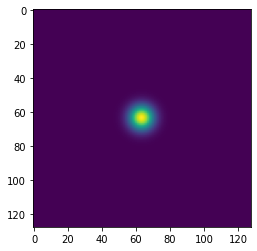

In [5]:
pattern = diffraction.get_diffraction_pattern(128,5)
plt.imshow(pattern)

The reason this looks "off" is that we haven't calibrated our pattern, once we do so we get a nice clean pattern

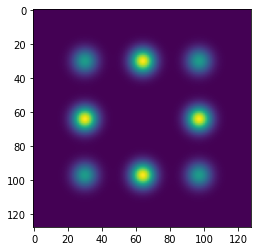

In [6]:
diffraction.calibration = 1e-2
pattern = diffraction.get_diffraction_pattern(128,5)
plt.imshow(pattern)

Define a distorted structure and simulate diffraction

In [7]:
latt = diffpy.structure.lattice.Lattice(3+0.12,3+0.12,3,90,90,90)
atom = diffpy.structure.atom.Atom(atype='Ni',xyz=[0,0,0],lattice=latt)
structure_d = diffpy.structure.Structure(atoms=[atom],lattice=latt)
diffractiond = ediff.calculate_ed_data(structure_d, reciprocal_radius=5.,
                                       max_excitation_error=0.025,
                                       with_direct_beam=False)
diffractiond.calibration = 1e-2
patternd = diffractiond.get_diffraction_pattern(128,5)

Copy the data and stitch patterns together with distortions applied to the patterns to make a 2x2 map

In [8]:
dp = pxm.signals.ElectronDiffraction2D((np.asarray([[pattern,patternd],[pattern,pattern]])))

x_l = []
for x in [0, 0, -0.01, 0.02]:
    x_s = np.eye(3)
    x_s[0,0] += x
    x_l.append(x_s)

angles = hs.signals.Signal2D(np.asarray(x_l).reshape(2,2,3,3))
dp = dp.apply_affine_transformation(D=angles,order=1,inplace=False)
dp.set_diffraction_calibration(1)

Plot the synthetic data to visualise distortions to be mapped

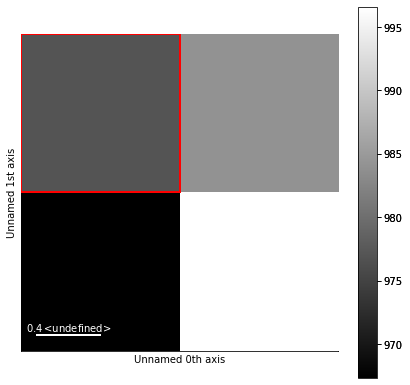

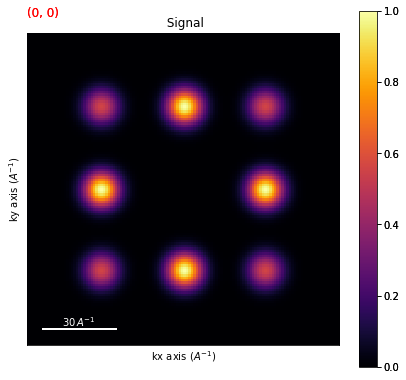

In [9]:
dp.plot(cmap='inferno')

<a id='vec'></a>

##  2. Vector Based Mapping

Import pyxem modules for vector based strain mapping

In [10]:
from pyxem.generators.subpixelrefinement_generator import SubpixelrefinementGenerator
from pyxem.signals.tensor_field import *
from pyxem.generators.displacement_gradient_tensor_generator import *

Finding the two peaks to be used for strain mapping

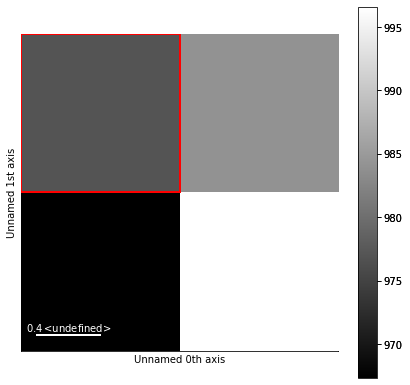

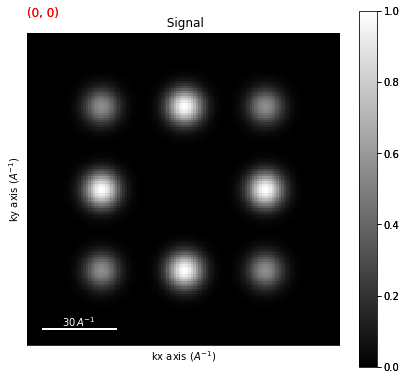

In [11]:
dp.plot()

x_peak = [24,0]
y_peak = [0,-42]

Determine peak positions to subpixel precision

In [12]:
spg = SubpixelrefinementGenerator(dp, np.asarray([x_peak,y_peak]))
Vs = spg.center_of_mass_method(20)

Compare distorted and undistorted diffraction vectors to obtain a strain map

In [13]:
D = get_DisplacementGradientMap(hs.signals.Signal2D(Vs), Vs.data[0,0])

In [14]:
# The warnings in this cell and the next one can be ignored and they will be removed in the next patch version
# see https://github.com/pyxem/pyxem/issues/716
strain_map = D.get_strain_maps()


[########################################] | 100% Completed |  0.1s


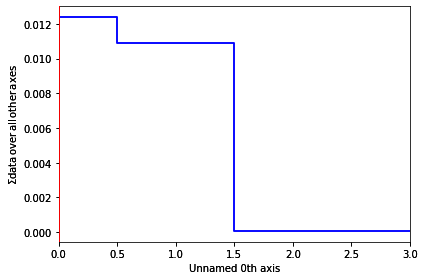

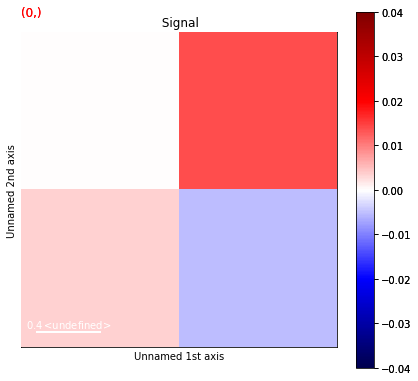

In [15]:
strain_map.plot(cmap='seismic',vmax=0.04,vmin=-0.04)